![title](img/logo.png)
# Biometrics System Concepts
## Assignment 1: Evaluating performance of biometric systems
<b>Name</b>: Marty McFly |
<b>Student-nr</b>: C25 |
<b>Date</b>: June 12, 2015
---

In this assignment we focus on evaluating the performance of any biometric system in a verification and identification setting. 

Before you get started you should be able to properly distinguish verification from identification and know the corresponding validation procedures. If this is not the case for you yet, **review the lecture notes!** We will give a short recap to refresh your memory: 
* **VERIFICATION** (a.k.a. authentication): Authenticating a claimed identity (is this person who he/she claims to be?).

* **IDENTIFICATION**: Associate a particular individual with an identity (who is this unidentified individual?).

This document is structured as follows:

- [I. Reading the data](#I.-Reading-the-data)
- [II. Validation of verification system](#II.-Validation-of-verification-system)
- [III. Validation of identification system](#III.-Validation-of-identification-system)
- [IV. Assignment Instructions](#IV.-Assignment-Instructions)


Code examples will be provided below. You can and are invited to adapt these at your will (different parameter settings, different choices of alogorithmic components). The code examples in this assignment are just sekeleton code,  **adapt where needed! And try to keep things structured!** 

In [1]:
# Install and import the required python packages to run this notebook. Feel free to add more packages whenever needed.

import numpy as np
import matplotlib.pyplot as plt
# the following meta-command is required to get plots displayed in notebooks
%matplotlib inline

# package for reading xml files
import xml.etree.ElementTree as ET

import os

# package for data analysis with fast and flexible data structures
import pandas as pd

# package to show a nice graphical progress-bar for lengthy calculations
# docu and installation on https://tqdm.github.io
# if you have difficulties installing this package: 
# - make sure your jupyter lab is up to date
# - https://github.com/tqdm/tqdm/issues/394#issuecomment-384743637
# - consider just leaving it out (just remove the 'tqdm_notebook' in the code)
from tqdm.notebook import tqdm as tqdm_notebook

# import local modules for reading and converting BSSR1 fingerprint score data
import src.BSSR1 as BSSR1
import pickle

from sklearn.metrics import roc_curve, det_curve, auc, f1_score, accuracy_score,roc_auc_score, precision_recall_curve, average_precision_score

<div class="alert alert-block alert-info">
<b>Tip:</b> 
Many operations have already been implemented in <a href="https://docs.scipy.org/doc/numpy/index.html">SciPy</a>, feel free to use them or any other unless explicitely stated not to in the assignment.</div>

## I. Reading the data
In this assignment we focus on the validation of a pre-exising biometric system. We will make use of actual predicted fingerprint similarity scores, from the left and right index fingers. This bypasses all steps of preprocessing, feature extraction and matching and allows us to concentrate on the score evaluation procedures. The scores are the result of comparing an enrolled user's image with that of the same (genuine scores) or another user (impostor scores). The data (biometrics scores set BSSR1) are made available through the American National Institute of Standards and Technologies [(NIST)](https://www.nist.gov/itl/iad/image-group/nist-biometric-scores-set-bssr1). They are provided as part of your assignment folder in the `data/fing-x-fing` subfolder. 

In this code example we will compare the performance of a biometric system that was based on the right index finger to a biometric system based on the left index finger. These systems are referred to as `ri` and `li` respectively in both code and text.  

### 1.1. Loading the similarity matrix and reading the genuine and impostor scores
We provide you with the code to read the scores from the files (normally you can leave this code as-is).

The code consits of 2 steps that are executed for both the `ri` and `li` system: 
1. Scores are converted to similarity matrices. To simplify the task we have provided you with the similarity matrices. You need to load the similarity matrices with the genuine scores on the diagonal and the impostor scores on the off-diagonal elements.  
2. Convert the original scores to a linear list of scores with associated labels of genuine or impostor (simplifies use of [scikit-learn](https://scikit-learn.org/stable/index.html))



In [2]:
# STEP 1: loading the similarity matrices for left and right index fingers
with open('./data/li_similarity_matrix.pickle', 'rb') as f:
    li_similarity_matrix = pickle.load(f)
with open('./data/ri_similarity_matrix.pickle', 'rb') as f:
    ri_similarity_matrix = pickle.load(f)

In [3]:
# STEP 2: convert to genuine and impostor scores, the *_genuine_id provides a mask for the genuine scores
li_genuine_id, li_scores = BSSR1.sim2scores(li_similarity_matrix)
ri_genuine_id, ri_scores = BSSR1.sim2scores(ri_similarity_matrix)

#converting to numpy array
li_genuine_id = np.array(li_genuine_id)
li_genuine_id = li_genuine_id.astype(int)
li_scores = np.array(li_scores)

ri_genuine_id = np.array(ri_genuine_id)
ri_genuine_id = ri_genuine_id.astype(int)
ri_scores = np.array(ri_scores)

<div class="alert alert-block alert-info">
<b>Tip:</b> 
In this assignment we focus only on evaluating biometric systems. It is in your best interest to write your code such that it can easily be reused in the upcoming assignments, where you will have to develop entire biometric system pipelines.</div>

## II. Validation of verification system

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)

The performance of a verification scenario can be expressed in a number of ways (see [Jain et al.][1] section 1.4.1.1 for more information). In essence one has a binary classification problem: is it the claimed identity or not? 

We denote our classes as:
<ol start="0">
  <li>Impostor (False),</li>
  <li>Genuine (True).</li>
</ol>

Furthermore, we represent the set of scores as s, the imposter event as $I$ and a genuine event as $G$.

In [129]:
# Get intuition about the data
print(np.min(ri_scores),np.max(ri_scores),np.shape(ri_scores))
print(np.shape(ri_genuine_id))
print('Number of Genuine samples' ,len(ri_scores[ri_genuine_id == 1]))
print(np.sum(ri_genuine_id[ri_genuine_id == 1])/np.shape(ri_genuine_id)[0])
print(np.shape(ri_genuine_id[ri_genuine_id == 1]))


print(np.min(li_scores),np.max(li_scores), np.shape(li_scores))
print(np.shape(li_genuine_id))
print('Number of Genuine samples' ,len(li_scores[li_genuine_id == 1]))
print(np.sum(li_genuine_id[li_genuine_id == 1])/np.shape(li_genuine_id)[0])

0.0 1.0 (1000000,)
(1000000,)
Number of Genuine samples 1000
0.001
(1000,)
0.0 1.0 (1000000,)
(1000000,)
Number of Genuine samples 1000
0.001


### 1. Evaluation using FMR, FRR, ROC and Precision/Recall curves

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)



#### 1.1 Genuine and impostor score distributions
Given the genuine and impostor scores (from section I), we can plot the imposter $p(s | I)$ and genuine $p(s | G)$ distribution to gain some first insights in the system. The result should look something like this:

<p align="center">
    <img src="img/ScoreDistributions.png" width="250" height="auto"/>
</p>


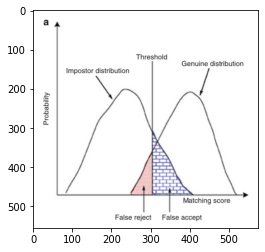

In [26]:
img = plt.imread('img/ScoreDistributions.png')
plt.imshow(img)
plt.show()

<div class="alert alert-block alert-success">
<b>Q1: </b> Score distributions
<ul>
  <li>Plot the genuine and impostor score distributions in a single plot.</li>
  <li>Do you need to normalize the distributions? Why (not)?</li>
  <li>Describe qualitatively this combined plot (hint: limit the score range for better understanding)</li>
</ul>  
</div>

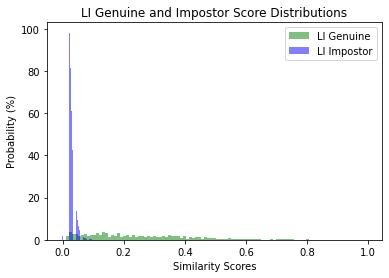

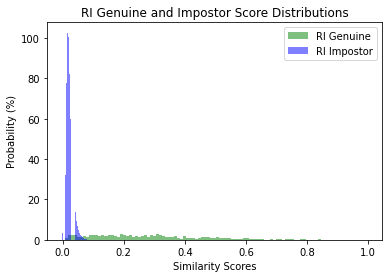

In [27]:
"""Plot the genuine and imposter score distributions."""
# Q1. Plot the genuine and impostor score distributions in a single plot.

def plot_score_distributions(scores, genuine_id, system_name):
    # Compute histograms of genuine and impostor scores
    
    genuine_hist, genuine_bins = np.histogram(scores[genuine_id == 1], bins=100, density=True)
    impostor_hist, impostor_bins = np.histogram(scores[genuine_id == 0], bins=100, density=True)

    # Plot histograms

    plt.bar(genuine_bins[:-1], genuine_hist, width=np.diff(genuine_bins), alpha=0.5, label=f'{system_name} Genuine', color='green')
    plt.bar(impostor_bins[:-1], impostor_hist, width=np.diff(impostor_bins), alpha=0.5, label=f'{system_name} Impostor', color='blue')

    plt.title(f'{system_name.upper()} Genuine and Impostor Score Distributions')
    plt.xlabel('Similarity Scores')
    plt.ylabel('Probability (%)')
    plt.legend()
    plt.show()
    
plot_score_distributions(li_scores, li_genuine_id, 'LI')
plot_score_distributions(ri_scores, ri_genuine_id, 'RI')

 🖊🖊  **Q2. Do you need to normalize the distributions? Why (not)?**

The density=True argument in the np.histogram() function call specifies that the histogram should be normalized so that the area under the histogram sums to 1. Therefore, the values in genuine_hist represent the probability density of the data points falling within each bin. So, we don't need other normalization and this normalization is essential because the vertical axis represent the probability and if we dont set density as True, it would show the number of samples on the vertical axis which is hardly interpretable

🖊🖊  **Q3. Describe qualitatively this combined plot (hint: limit the score range for better understanding)?**

The combined plot shows the genuine and impostor score distributions for two different biometric modalities: left fingerprints identification (LI) and right fingerprints identification (RI). Each modality has two histograms, one for genuine scores (scores from the same individual) and one for impostor scores (scores from different individuals).

Looking at the LI histograms, we can see that genuine scores (green) have higher values than impostor scores (blue) for most of the score range, indicating that the LI modality is able to differentiate well between individuals. The highest values for genuine scores occur at around 0.15, while the highest values for impostor scores occur at around 0.06.

The RI histograms show a similar pattern, with genuine scores (red) higher than impostor scores (black) for most of the score range. The highest values for genuine scores occur at around 0.17, while the highest values for impostor scores occur at around 0.08.

Comparing the two modalities, we can see that the RI modality seems to have slightly better performance than the LI modality, as the genuine scores are generally higher and the impostor scores are generally lower. However, the difference in performance is not large, and both modalities appear to be able to differentiate well between genuine and impostor scores. Overall, the combined plot provides a useful visualization of the performance of the two biometric modalities.

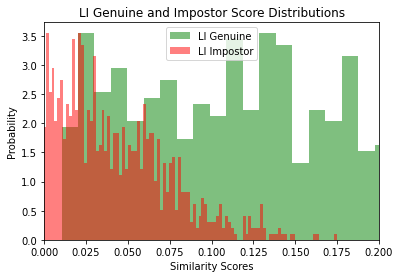

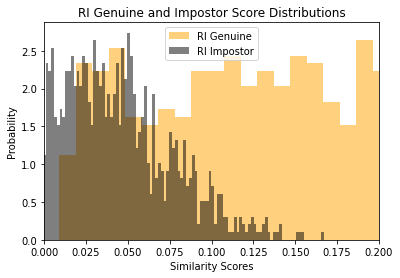

In [36]:
def plot_score_distributions_V2(scores, genuine_id, system_name, x1, x2, color_genuine, color_impostor):
    # Compute histograms of genuine and impostor scores
    
    genuine_hist, genuine_bins = np.histogram(scores[genuine_id == 1], bins=100, density=True)
    impostor_hist, impostor_bins = np.histogram(scores[genuine_id == 0], bins=100, density=True)

    # Set x-axis limits to zoom in on scores between 0 and 0.2
    plt.xlim(x1, x2) 

    # Plot histograms

    plt.bar(genuine_bins[:-1], genuine_hist, width=np.diff(genuine_bins), alpha=0.5, label=f'{system_name} Genuine', color=color_genuine)
    plt.bar(impostor_bins[:-1], genuine_hist, width=np.diff(impostor_bins), alpha=0.5, label=f'{system_name} Impostor', color=color_impostor)

    plt.title(f'{system_name.upper()} Genuine and Impostor Score Distributions')
    plt.xlabel('Similarity Scores')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

plot_score_distributions_V2(li_scores, li_genuine_id, 'LI', 0, 0.2, 'green', 'red')
plot_score_distributions_V2(ri_scores, ri_genuine_id, 'RI', 0, 0.2, 'orange', 'black')

#### 2. FMR, FRR and Receiver Operating Characteristic (ROC) curve

The 'false accept' and 'false reject' regions in the illustration above are quantified using the False Match/Acceptance Rates (FMR/FAR) and False Non-Match/Rejections Rates (FNMR/FRR). The FMR and FNMR can easily be computed given the previously calculated probability distributions and a threshold value $\eta$. Practically this boils down to a counting problem, having $\mathcal{I}$ the indicator function (return 1 if x is true, else 0) we can compute:
$$
FMR(\eta) = p(s \geq \eta | I) \approx \frac{1}{|I|} \sum_{s \in I} \mathcal{I}(s \geq \eta),
$$
$$
FRR(\eta) = p(s < \eta | G) \approx \frac{1}{|G|} \sum_{s \in G} \mathcal{I}(s < \eta).
$$

We can also compute the Genuine Acceptance Rate (GAR)/True Match Rate (TMR) as:
$$
GAR(\eta) = p(s \geq \eta | G) = 1 - FRR(\eta).
$$

Note that choosing a threshold is always a tradeof between FMR and FNMR. <br>
<img src="img/FAR_FRR.png" width="300" height="auto" align="center"/>

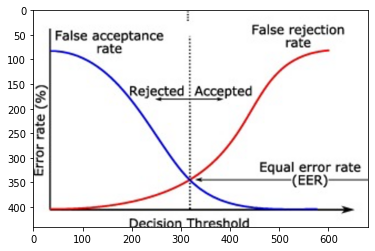

In [37]:
img = plt.imread('img/FAR_FRR.png')
plt.imshow(img)
plt.show()

To observe the impact of the threshold value, one often plots a Receiver Operating Characteristic (ROC) curve. Usually in these curves the GAR/TMR is plotted against the FMR for different decision threshold values  η . For those familiar with binary classification systems outside of the biometrics literature; the GAR/TMR is often referred to as the True Positive Rate (TPR), sensitivity or recall and FMR is also known as the False Positive Rate (FPR) or the False Accept Rate (FAR).

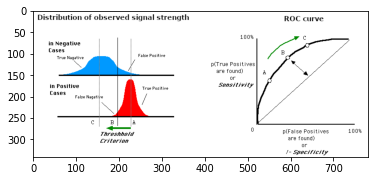

In [38]:
img = plt.imread('img/ROC.png')
plt.imshow(img)
plt.show()

<div class="alert alert-block alert-success">
<b>Q2: </b> ROC Curves
<ul>
    <li>Calculate FPR, TPR from the matching scores.</li>
    <li>Plot FAR and FRR as a function of matching scores.</li>
    <li>Plot the ROC curve. Plot for linear and logarithmic scale if needed. What do you observe?</li>
    <li>Plot the Detection Error Trade-off (DET) curve. How does it compare to ROC?</li>
</ul>  
</div>


<div class="alert alert-block alert-info">
<b>Tip:</b> 
We highly recommend you use the <a href="https://scikit-learn.org/stable/index.html">scikit-learn</a> package, it contains standard and advanced routines for machine learning, including classificaton and validation algorithms.
</div>

In [4]:
"""Calculate FPR, TPR from the matching scores."""
# Compute false positive rate and true positive rate
li_fpr, li_tpr, li_thresholds = roc_curve(li_genuine_id, li_scores)
ri_fpr, ri_tpr, ri_thresholds = roc_curve(ri_genuine_id, ri_scores)

0.04580152671755725
0.045454545454545456


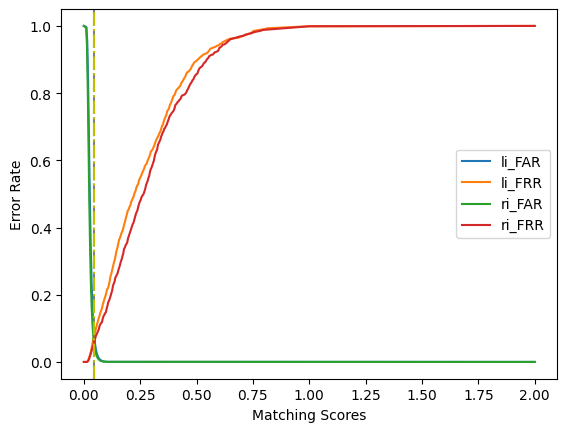

In [20]:
"""Plot FAR and FRR as a function of the decision threshold."""

def plot_FAR_FRR(scores, genuine_id, system_name):
  # FAR <=> FPR
  # FRR <=> FNR <=> FN/P <=> 1-TPR

  # Compute false positive rate and true positive rate
  fpr, tpr, thresholds = roc_curve(genuine_id, scores)

  # compute the false acceptance rate (FAR) and false rejection rate (FRR) for each threshold
  frr = 1 - tpr
  far = fpr

  # Compute equal error rate (EER) and its threshold
  eer_idx = np.argmin(np.abs(far - frr))
  eer = (far[eer_idx] + frr[eer_idx]) / 2
  eer_threshold = thresholds[eer_idx]

  print(eer_threshold)

  return eer_threshold, far, frr

li_eer_threshold, li_far, li_frr = plot_FAR_FRR(li_scores, li_genuine_id, "LI")
rieer_threshold, ri_far, ri_frr = plot_FAR_FRR(ri_scores, ri_genuine_id, "RI")

# plot the FAR and FRR curves as a function of matching scores
plt.plot(li_thresholds, li_far, label='li_FAR')
plt.plot(li_thresholds, li_frr, label='li_FRR')
plt.axvline(li_eer_threshold, color='gray', linestyle='--')

plt.plot(ri_thresholds, ri_far, label='ri_FAR')
plt.plot(ri_thresholds, ri_frr, label='ri_FRR')
plt.axvline(li_eer_threshold, color='y', linestyle='-.')

plt.xlabel('Matching Scores')
plt.ylabel('Error Rate')
# plt.title(f'False Acceptance Rate (FAR) and False Rejection Rate (FRR) in {system_name}')
plt.legend()
plt.show()

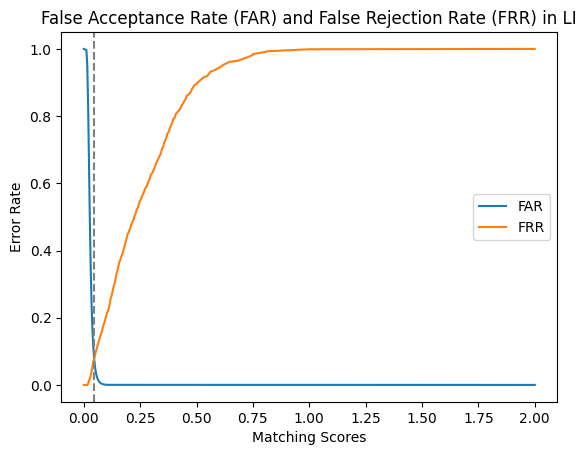

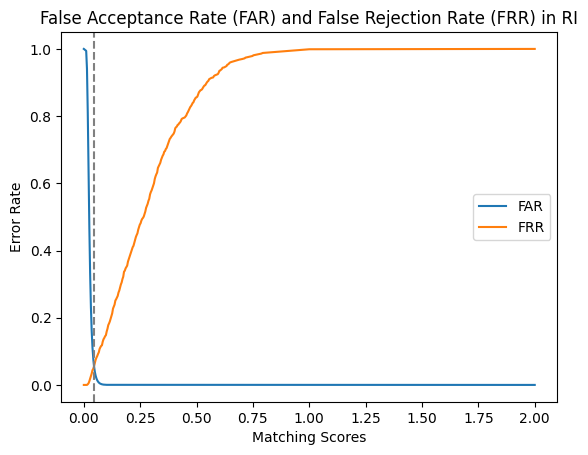

In [11]:
"""Plot FAR and FRR as a function of the decision threshold."""

def plot_FAR_FRR(scores, genuine_id, system_name):
  # FAR <=> FPR
  # FRR <=> FNR <=> FN/P <=> 1-TPR

  # Compute false positive rate and true positive rate
  fpr, tpr, thresholds = roc_curve(genuine_id, scores)

  # compute the false acceptance rate (FAR) and false rejection rate (FRR) for each threshold
  frr = 1 - tpr
  far = fpr

  # Compute equal error rate (EER) and its threshold
  eer_idx = np.argmin(np.abs(far - frr))
  eer = (far[eer_idx] + frr[eer_idx]) / 2
  eer_threshold = thresholds[eer_idx]

  # plot the FAR and FRR curves as a function of matching scores
  plt.plot(thresholds, fpr, label='FAR')
  plt.plot(thresholds, frr, label='FRR')
  plt.axvline(eer_threshold, color='gray', linestyle='--')
  plt.xlabel('Matching Scores')
  plt.ylabel('Error Rate')
  plt.title(f'False Acceptance Rate (FAR) and False Rejection Rate (FRR) in {system_name}')
  plt.legend()
  plt.show()

plot_FAR_FRR(li_scores, li_genuine_id, "LI")
plot_FAR_FRR(ri_scores, ri_genuine_id, "RI")

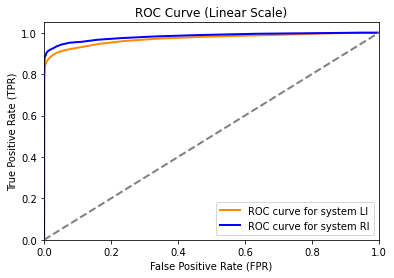

In [77]:
"""plot the ROC curve (TPR against the FPR for different threshold values)--- Linear"""

li_fpr, li_tpr, li_thresholds = roc_curve(li_genuine_id, li_scores)
ri_fpr, ri_tpr, ri_thresholds = roc_curve(ri_genuine_id, ri_scores)

# plot the ROC curve with linear scale
plt.figure()
plt.plot(li_fpr, li_tpr, color='darkorange', lw=2, label='ROC curve for system LI')
plt.plot(ri_fpr, ri_tpr, color='blue', lw=2, label='ROC curve for system RI')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve (Linear Scale)')
plt.legend(loc="lower right")
plt.show()

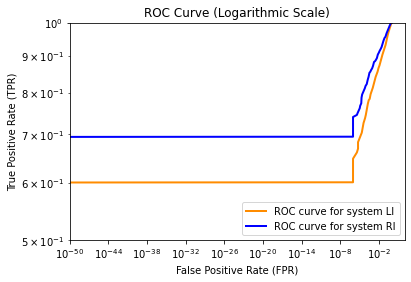

In [78]:
"""plot the ROC curve (TPR against the FPR for different threshold values)--- Log"""

li_fpr, li_tpr, li_thresholds = roc_curve(li_genuine_id, li_scores)
ri_fpr, ri_tpr, ri_thresholds = roc_curve(ri_genuine_id, ri_scores)

# plot the ROC curve with linear scale
plt.figure()
plt.plot(li_fpr, li_tpr, color='darkorange', lw=2, label='ROC curve for system LI')
plt.plot(ri_fpr, ri_tpr, color='blue', lw=2, label='ROC curve for system RI')
plt.xscale('log')
plt.yscale('log')
plt.xlim([10 ** -50, 100])
plt.ylim([5*10 ** -1, 1])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve (Logarithmic Scale)')
plt.legend(loc="lower right")
plt.show()



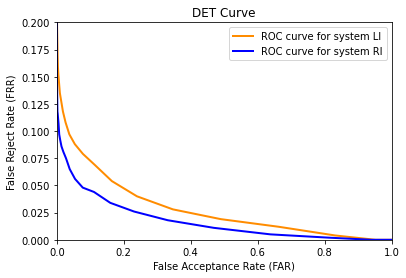

In [66]:
"""plot the DET curve (FRR (=1-tpr) against the FAR for different threshold values)"""

# FAR <=> FPR
# FRR <=> FNR <=> FN/P <=> 1-TPR

# compute the false positive rate (FPR), false negative rate (FNR), and thresholds

li_fpr, li_tpr, li_thresholds = roc_curve(li_genuine_id, li_scores)
ri_fpr, ri_tpr, ri_thresholds = roc_curve(ri_genuine_id, ri_scores)

li_FAR = li_fpr
ri_FAR = ri_fpr

li_FRR = 1- li_tpr
ri_FRR = 1- ri_tpr

# plot the ROC curve with linear scale
plt.figure()
plt.plot(li_FAR, li_FRR, color='darkorange', lw=2, label='ROC curve for system LI')
plt.plot(ri_FAR, ri_FRR, color='blue', lw=2, label='ROC curve for system RI')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 0.2])
plt.xlabel('False Acceptance Rate (FAR)')
plt.ylabel('False Reject Rate (FRR)')
plt.title('DET Curve')
plt.legend(loc="upper right")
plt.show()

#### 3. F1 and accuracy as metrics

While biometric systems are, traditionally, evaluated using FMR and FRR and ROC/DET curves, we can also have a look at traditional [classification metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) such as classification accuracy (or error) and F1 measure. 

<div class="alert alert-block alert-success">
<b>Q3: </b> Classification Metrics
<ul>
    <li>Plot F1 and accuracy as a function of the decision thresholds on the similarity score.</li>
    <li>Calculate the threshold and accuracy for which F1 is maximal. Is it an interesting operating point?</li>
    <li>Do the same for the classification error (accuracy). Is there a difference?</li>
    <li>Is accuracy a good performance metric in this case?</li>
</ul>  
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> 
We highly recommend you use the <a href="https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics">scikit-learn classification metrics</a> to assist.
</div>


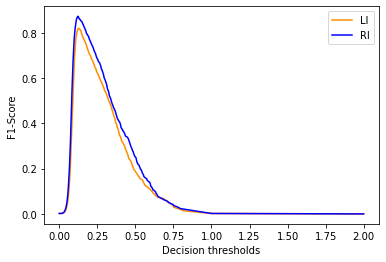

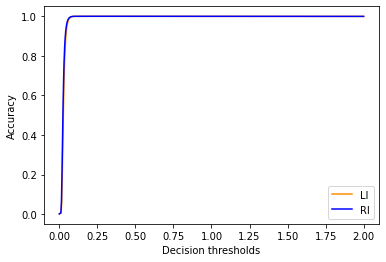

In [117]:
"""Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
# Hint: evaluating for ± 50 threshold values should suffice

def calculate_F1_and_Acc(scores, genuine_id, system_name):
  fpr, tpr, threshold_values = roc_curve(genuine_id, scores)
  f1_scores = np.zeros(len(threshold_values))
  accuracy_scores = np.zeros(len(threshold_values))

  # Compute F1 and accuracy scores for each threshold value
  for i, threshold in enumerate(threshold_values):
    predicted_labels = (scores >= threshold).astype(int)
    f1_scores[i] = f1_score(genuine_id, predicted_labels)
    accuracy_scores[i] = accuracy_score(genuine_id, predicted_labels)
  
  return accuracy_scores, f1_scores, threshold_values

li_accuracy_scores, li_f1_scores, li_threshold_value = calculate_F1_and_Acc(li_scores, li_genuine_id, 'LI')
ri_accuracy_scores, ri_f1_scores, ri_threshold_value = calculate_F1_and_Acc(ri_scores, ri_genuine_id, 'RI')

# Plot F1 and accuracy scores as a function of threshold values
plt.plot(li_threshold_value, li_f1_scores, label='LI', color='darkorange')
plt.plot(ri_threshold_value, ri_f1_scores, label='RI', color='blue')
plt.ylabel('F1-Score')
plt.xlabel('Decision thresholds')
plt.legend()
plt.show()

plt.plot(li_threshold_value, li_accuracy_scores, label='LI', color='darkorange')
plt.plot(ri_threshold_value, ri_accuracy_scores, label='RI', color='blue')
plt.ylabel('Accuracy')
plt.xlabel('Decision thresholds')
plt.legend()
plt.show()

In [118]:
"""Calculate the threshold and accuracy for which F1 is maximal."""
# Find the threshold for maximal F1 score
def accuracy_at_max_f1(scores, genuine_id, system_name):
  accuracy_scores, f1_scores, threshold_values = calculate_F1_and_Acc(scores, genuine_id, system_name)
  max_f1_index = np.argmax(f1_scores)
  f1_scores_max = f1_scores[max_f1_index]
  max_f1_threshold = threshold_values[max_f1_index]
  accuracy_at_max = accuracy_scores[max_f1_index]
  print(f'For system {system_name}, the maximum F1-score is {f1_scores_max}, and it occurs at a threshold of {max_f1_threshold}.At this threshold, the corresponding accuracy is {accuracy_at_max}.')

li_max_f1_threshold = accuracy_at_max_f1(li_scores, li_genuine_id, 'LI')
ri_max_f1_threshold = accuracy_at_max_f1(ri_scores, ri_genuine_id, 'RI')

For system LI, the maximum F1-score is 0.8208027133973996, and it occurs at a threshold of 0.12595419847328243.At this threshold, the corresponding accuracy is 0.999683.
For system RI, the maximum F1-score is 0.8731466227347611, and it occurs at a threshold of 0.12237762237762238.At this threshold, the corresponding accuracy is 0.999769.


In [74]:
"""Do the same for the classification error (or accuracy)"""

def f1_at_max_acuracy(scores, genuine_id, system_name):
  accuracy_scores, f1_scores, threshold_values = calculate_F1_and_Acc(scores, genuine_id, system_name)
  max_acc_index = np.argmax(accuracy_scores)
  acc_max = accuracy_scores[max_acc_index]
  max_acc_threshold = threshold_values[max_acc_index]
  f1_at_max = f1_scores[max_acc_index]
  print(f'For system {system_name}, the maximum accuracy is {acc_max}, and it occurs at a threshold of {max_acc_threshold}.At this threshold, the corresponding F1-Score is {f1_at_max}.')

li_max_f1_threshold = f1_at_max_acuracy(li_scores, li_genuine_id, 'LI')
ri_max_f1_threshold = f1_at_max_acuracy(ri_scores, ri_genuine_id, 'RI')


For system LI, the maximum accuracy is 0.999681, and it occurs at a threshold of 0.13131313131313133.At this threshold, the corresponding F1-Score is 0.8152866242038217.
For system RI, the maximum accuracy is 0.999769, and it occurs at a threshold of 0.12121212121212122.At this threshold, the corresponding F1-Score is 0.8731466227347611.


🖊🖊 **Is accuracy a good performance metric in this case?**

No, accuracy may not be a good performance metric in this case because the data seems to be imbalanced with a very high accuracy score and a very low F1 score. This suggests that the majority class is being correctly classified, while the minority class is being misclassified. In such cases, other evaluation metrics like F1 score, precision, recall, AUC-ROC, etc., should be used to get a more complete picture of the model's performance. These metrics take into account both false positives and false negatives, which is particularly important when dealing with imbalanced datasets.

#### 4. AUC and EER as summary measures

The overall performance (over all threshold settings) is typically expressed through:

* The Area Under the Curve (AUC) (with TPR((y-axis) vs FPR (x-axis))

<img src="img/AUC.png" width="250" height="auto"/>


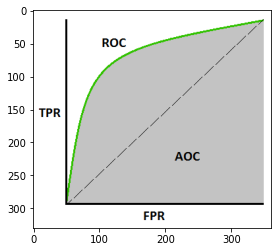

In [75]:
img = plt.imread("img/AUC.png")
plt.imshow(img)
plt.show()

The AUC can be used to compare different systems. The larger this number, the better.
However, since it is a summary measure, always inspect the full ROC curve to make decisions about performance given operating conditions (in wich FRR, FAR regime to work e.g.).

* The Equal Error Rate (EER), which is the point on the ROC-curve where FAR(FMR) equals FRR (1-TAR). A lower EER value indicates better performance. 

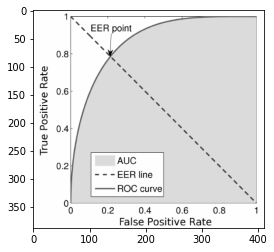

In [76]:
img = plt.imread('img/EER.png')
plt.imshow(img)
plt.show()

<div class="alert alert-block alert-success">
<b>Q4: </b> AUC, EER and alternatives
<ul>
    <li>Calculate ROC AUC. Is this a good metric? What does it reveal about the system? </li>
    <li>Calculate (by approximation) the EER and plot it on the FAR-FRR curve. Is this a good peration point?</li>
    <li>Calculate the decision threshold for which the sum of FRR and FAR is minimal. Is this point similar to the total classification error?</li> 
    <li>Can you suggest other strategies that give you an "optimal" performance? Calculate and discuss their (de)merits.</li>
</ul>  
</div>


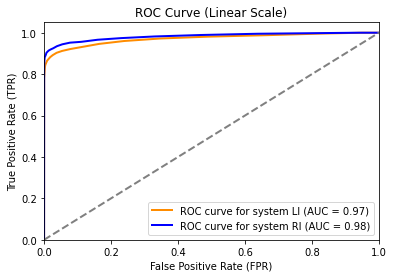

In [97]:
"""Calculate the ROC AUC."""

"""plot the ROC curve (TPR against the FPR for different threshold values)--- Linear"""

li_fpr, li_tpr, li_thresholds = roc_curve(li_genuine_id, li_scores)
ri_fpr, ri_tpr, ri_thresholds = roc_curve(ri_genuine_id, ri_scores)

# compute the AUC score
li_roc_auc = auc(li_fpr, li_tpr)
ri_roc_auc = auc(ri_fpr, ri_tpr)

# plot the ROC curve with linear scale
plt.figure()
plt.plot(li_fpr, li_tpr, color='darkorange', lw=2, label='ROC curve for system LI (AUC = %0.2f)' % li_roc_auc)
plt.plot(ri_fpr, ri_tpr, color='blue', lw=2, label='ROC curve for system RI (AUC = %0.2f)' % ri_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve (Linear Scale)')
plt.legend(loc="lower right")
plt.show()

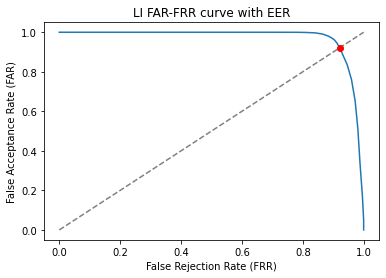

 In LI system, EER is  0.9215325325325325


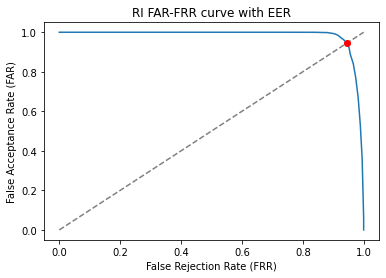

 In RI system, EER is  0.9447982982982983


In [99]:
"""Calculate (by approximation) the EER and plot it on the FAR-FRR curve."""
# hints:
#  - avoid using a library that directly computes the EER for this assignment 

def compute_eer(similarity_scores, genuine_labels, system_name):
    # Convert the similarity scores to distances
    distances = 1 - np.array(similarity_scores)

    # Generate the true labels (0 for impostors, 1 for genuine)
    labels = np.array(genuine_labels)

    # Calculate the FPR and TPR values for different thresholds
    fpr, tpr, thresholds = roc_curve(labels, distances)

    # Calculate the FAR and FRR values for different thresholds
    frr = 1 - tpr
    far = fpr

    # Find the point on the FAR-FRR curve where the difference between the FAR and FRR is the smallest
    eer_threshold_idx = np.argmin(np.abs(far - frr))
    eer = (far[eer_threshold_idx] + frr[eer_threshold_idx]) / 2

    # Plot the FAR-FRR curve and the EER
    plt.plot(frr, far)
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.plot(eer, eer, marker='o', color='red')
    plt.ylabel('False Acceptance Rate (FAR)')
    plt.xlabel('False Rejection Rate (FRR)')
    plt.title(f'{system_name} FAR-FRR curve with EER')
    plt.show()

    print(f' In {system_name} system, EER is ', eer)

compute_eer(li_scores, li_genuine_id, 'LI')
compute_eer(ri_scores, ri_genuine_id, 'RI')

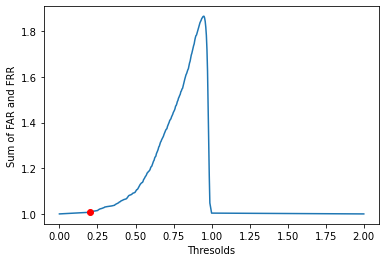

 In system LI, the minimal sum of FRR and FAR is 1.0070000000000001 and it happens at decision threshold 0.1984732824427481


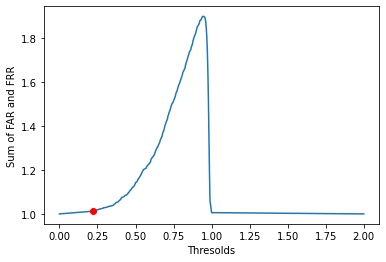

 In system RI, the minimal sum of FRR and FAR is 1.012 and it happens at decision threshold 0.22027972027972031


In [121]:
"""Calculate the decision threshold for which the sum of FRR and FAR is minimal."""
# hint: same as above

def compute_threshold_with_min_frr_plus_far(similarity_scores, genuine_labels, system_name):

    # Convert the similarity scores to distances
    distances = 1 - np.array(similarity_scores)

    # Generate the true labels (0 for impostors, 1 for genuine)
    labels = np.array(genuine_labels)

    # Calculate the FPR and TPR values for different thresholds
    fpr, tpr, thresholds = roc_curve(labels, distances)

    # Calculate the FAR and FRR values for different thresholds
    frr = 1 - tpr
    far = fpr

    # Calculate the sum of FRR and FAR for different thresholds
    frr_plus_far = frr + far

    # Find the threshold for which the sum of FRR and FAR is minimal
    frr_plus_far_within_range = frr_plus_far[(thresholds > 0) & (thresholds < 1)]
    min_frr_plus_far_threshold_idx = np.argmin(frr_plus_far_within_range)
    min_value = frr_plus_far_within_range[min_frr_plus_far_threshold_idx]
    threshold = thresholds[(thresholds > 0) & (thresholds <= 1)][min_frr_plus_far_threshold_idx]

    # Plot the FAR-FRR curve and the EER
    plt.plot(thresholds, frr_plus_far)
    plt.plot(threshold, min_value, marker='o', color='red')
    plt.ylabel('Sum of FAR and FRR')
    plt.xlabel('Thresolds')
    plt.show()

    print(f" In system {system_name}, the minimal sum of FRR and FAR is {min_value} and it happens at decision threshold",threshold )

    return threshold

li_threshold = compute_threshold_with_min_frr_plus_far(li_scores, li_genuine_id, 'LI')
ri_threshold = compute_threshold_with_min_frr_plus_far(ri_scores, ri_genuine_id, 'RI')

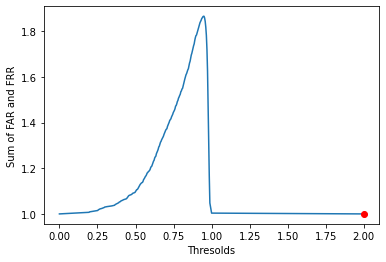

 In system LI, the minimal sum of FRR and FAR is 1.0 and it happens at decision threshold 2.0


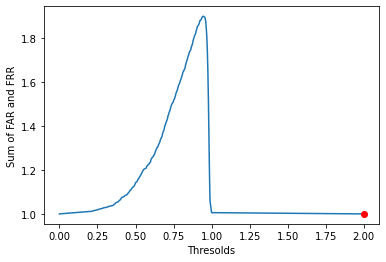

 In system RI, the minimal sum of FRR and FAR is 1.0 and it happens at decision threshold 2.0


In [103]:
"""Calculate the decision threshold for which the sum of FRR and FAR is minimal."""
# hint: same as above

def compute_threshold_with_min_frr_plus_far(similarity_scores, genuine_labels, system_name):

    # Convert the similarity scores to distances
    distances = 1 - np.array(similarity_scores)

    # Generate the true labels (0 for impostors, 1 for genuine)
    labels = np.array(genuine_labels)

    # Calculate the FPR and TPR values for different thresholds
    fpr, tpr, thresholds = roc_curve(labels, distances)

    # Calculate the FAR and FRR values for different thresholds
    frr = 1 - tpr
    far = fpr

    # Calculate the sum of FRR and FAR for different thresholds
    frr_plus_far = frr + far

    # Find the threshold for which the sum of FRR and FAR is minimal
    min_frr_plus_far_threshold_idx = np.argmin(frr_plus_far)
    min_value = frr_plus_far[min_frr_plus_far_threshold_idx]
    threshold = thresholds[min_frr_plus_far_threshold_idx]

    # Plot the FAR-FRR curve and the EER
    plt.plot(thresholds, frr_plus_far)
    plt.plot(threshold, min_value, marker='o', color='red')
    plt.ylabel('Sum of FAR and FRR')
    plt.xlabel('Thresolds')
    plt.show()

    print(f" In system {system_name}, the minimal sum of FRR and FAR is {min_value} and it happens at decision threshold",threshold )

    return threshold

li_threshold = compute_threshold_with_min_frr_plus_far(li_scores, li_genuine_id, 'LI')
ri_threshold = compute_threshold_with_min_frr_plus_far(ri_scores, ri_genuine_id, 'RI')

#### 5. Evaluation using Precision and Recall

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)
[3]: <https://en.wikipedia.org/w/index.php?title=Information_retrieval&oldid=793358396#Average_precision> (Average precision)

In a general binary classification setting, one also often presents Precision-Recall curves. PR-curves are sometimes summarized using the [average precision scores][3]. How and when to use ROC or PRC is discussed [here][2]. A more general discussion of these measures is provided [here](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c).  

Scikit-Learn provides routines for calculating these curves and numbers as demonstrated in the code below from this [link][2], it also provides an implementation of the [average precision scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score).


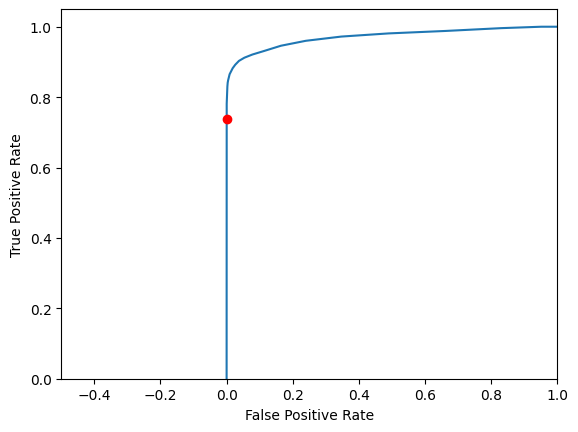

In system LI, the maximal Matthews Correlation Coefficient is 0.8277467727657398 and it happens at decision threshold 0.12213740458015267


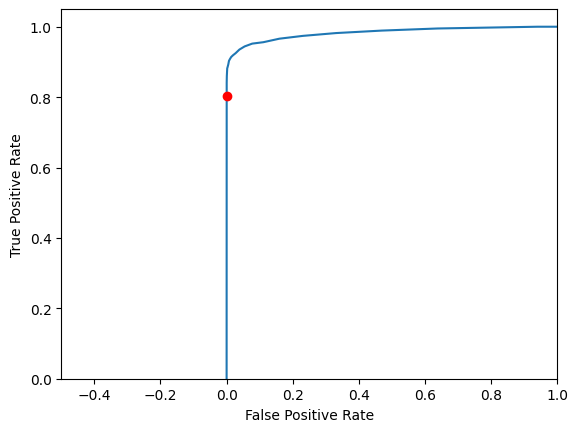

In system RI, the maximal Matthews Correlation Coefficient is 0.8772884820434471 and it happens at decision threshold 0.11888111888111888


In [7]:
from sklearn.metrics import matthews_corrcoef, roc_curve

# Can you suggest other strategies that give you an "optimal" performance? Calculate and discuss their (de)merits.

def compute_mcc_with_optimal_threshold(similarity_scores, genuine_labels, system_name):

    # Generate the true labels (0 for impostors, 1 for genuine)
    labels = np.array(genuine_labels)

    # Calculate the false positive rate, true positive rate and thresholds for different operating points
    fpr, tpr, thresholds = roc_curve(labels, similarity_scores)

    # Calculate the Matthews Correlation Coefficient for different thresholds
    mcc_values = [matthews_corrcoef(labels, similarity_scores > threshold) for threshold in thresholds]

    # Find the threshold that maximizes MCC
    max_mcc_idx = np.argmax(mcc_values)
    max_value = mcc_values[max_mcc_idx]
    threshold = thresholds[max_mcc_idx]

    # Plot the ROC curve and the optimazl operating point
    plt.plot(fpr, tpr)
    plt.plot(fpr[max_mcc_idx],tpr[max_mcc_idx], marker='o', color='red')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.xlim([-0.1, 1.0])
    plt.ylim([0, 1.05])
    plt.show()

    print(f"In system {system_name}, the maximal Matthews Correlation Coefficient is {max_value} and it happens at decision threshold", threshold)

    return threshold, max_value

li_threshold, li_max_value = compute_mcc_with_optimal_threshold(li_scores, li_genuine_id, 'LI')
ri_threshold, ri_max_value = compute_mcc_with_optimal_threshold(ri_scores, ri_genuine_id, 'RI')

<div class="alert alert-block alert-success">
<b>Q5: </b> Precision-Recall curves and related summary measures
<ul>
    <li>Calculate and plot the Precision-Recall curve for this system. What does it reveal about the performance of the system?</li>
    <li>Calculate the Area Under the PR-curve. Discuss.</li>
    <li>Calculate the average precision scores. Discuss its value.</li> 
</ul>  
</div>


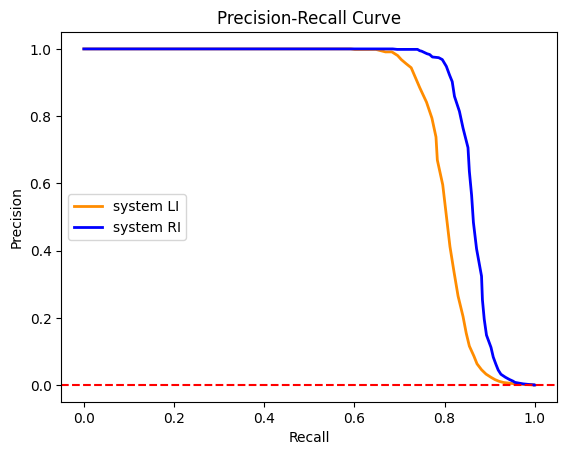

In [10]:
"""Calculate and plot the Precision-Recall curve for this system"""


li_precision, li_recall, li_thresholds = precision_recall_curve(li_genuine_id, li_scores)
ri_precision, ri_recall, ri_thresholds = precision_recall_curve(ri_genuine_id, ri_scores)

# plot the ROC curve with linear scale
plt.figure()
plt.plot(li_recall, li_precision, color='darkorange', lw=2, label='system LI')
plt.plot(ri_recall, ri_precision, color='blue', lw=2, label='system RI')
P_normal = np.sum(ri_genuine_id[ri_genuine_id == 1])/np.shape(ri_genuine_id)[0]
plt.axhline(y=P_normal, color='r', linestyle='--')
# plt.ylim([0, 0.01])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [137]:
"""Calculate the Area Under the PR-curve."""

def Area_Under_the_PR_curve(genuine_id, scores, system_name):
  precision, recall, _ = precision_recall_curve(genuine_id, scores)
  auc_ = auc(recall, precision)
  print(f'Area under the PR-curve for {system_name}: {auc_}')

Area_Under_the_PR_curve(li_genuine_id, li_scores, "LI")
Area_Under_the_PR_curve(ri_genuine_id, ri_scores, "RI")

Area under the PR-curve for LI: 0.8034780801507486
Area under the PR-curve for RI: 0.8627573994779723


In [139]:
"""Calculate the average precision scores"""
def Avg_precision(genuine_id, scores, system_name):
  precision, recall, _ = precision_recall_curve(genuine_id, scores)
  precision = np.array(precision)
  avg = np.average(precision)
  print(avg)
  return avg

Avg_precision(li_genuine_id, li_scores, "LI")
Avg_precision(ri_genuine_id, ri_scores, "RI")

0.8772400258299748
0.8893831374836604


0.8893831374836604

## III. Validation of identification system 

### Evaluation using CMC curves
In an identification scenario one has a 1-to-many or multi-class classification problem. The performance of such a system is typically measured by the Cumulative Match Characteristic (CMC) curve. This curve plots the experimental probability that a correct identification is returned within the top-x (x=1, ..., N) ranked matching scores. 


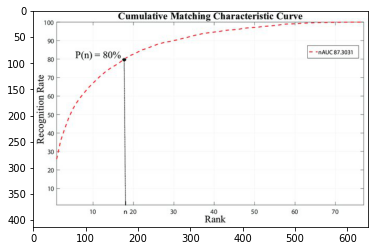

In [140]:
img = plt.imread('img/CMC.jpg')
plt.imshow(img)
plt.show()

[Bolle et al.](https://ieeexplore.ieee.org/document/1544394) show that:
> the CMC is also related to the FAR and FRR of a 1:1 matcher, i.e., the matcher that is used to rank the candidates by sorting the scores. This has as a consequence that when a 1:1 matcher is used for identification, that is, for sorting match scores from high to low, the CMC does not offer any additional information beyond the FAR and FRR curves. The CMC is just another way of displaying the data and can be computed from the FAR and FRR.

This paper is not mandatory but those interested can have a look at it.

CMC curves can easily be generated once you have the ranked matching scores for every test sample. In our example we can easily calculate it from the similarity matrix (note that in this very particular case we have only one genuine pair per test sample). 



<div class="alert alert-block alert-success">
<b>Q6: </b> CMC curves
<ul>
    <li>Calculate the Cumulative Matching Characteristic curve (implement this yourself)</li>
    <li>Compute the Rank-1 Recognition Rate.</li>
</ul>  
</div>


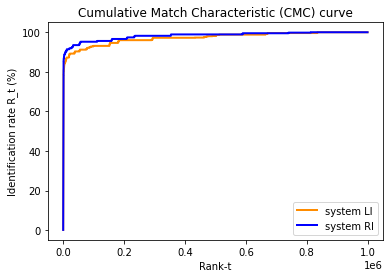

In [160]:
"""Calculate the Cumulative Matching Characteristic curve."""
# Hint: don't use a library

def calculate_cmc(scores, labels):
    # Sort the scores and labels in descending order
    sorted_indices = np.argsort(scores)[::-1]
    sorted_scores = scores[sorted_indices]
    sorted_labels = np.array(labels)[sorted_indices]

    # Calculate the number of genuine matches at each rank
    genuine_matches = np.cumsum(sorted_labels)

    # Calculate the rank-t identification rate R_t for t = 1, 2, ..., N
    identification_rates = (genuine_matches / np.sum(labels)) * 100

    return identification_rates


li_identification_rates = calculate_cmc(li_scores, li_genuine_id)
ri_identification_rates = calculate_cmc(ri_scores, ri_genuine_id)

# plot the ROC curve with linear scale
plt.figure()
# plt.xlim(1,1000)
plt.plot(range(1, len(li_scores)+1), li_identification_rates, color='darkorange', lw=2, label='system LI')
plt.plot(range(1, len(ri_scores)+1), ri_identification_rates, color='blue', lw=2, label='system RI')
plt.xlabel('Rank-t')
plt.ylabel('Identification rate R_t (%)')
plt.title('Cumulative Match Characteristic (CMC) curve')
plt.legend()
plt.show()

In [156]:
"""compute the Rank-1 Recognition Rate."""

li_identification_rates = calculate_cmc(li_scores, li_genuine_id)
ri_identification_rates = calculate_cmc(ri_scores, ri_genuine_id)

li_rank1_Recognition_rate = li_identification_rates[0]
ri_rank1_Recognition_rate = ri_identification_rates[0]

print(li_rank1_Recognition_rate)
print(ri_rank1_Recognition_rate)

0.1
0.1


<div class="alert alert-block alert-success">
<b>Q7: </b> Evaluate different biometric systems
<ul>
    <li>Use above evaluation techniques to compare the biometric system based on the left index to the right index </li>
    <li>Do you see any differences in any of the curves or measures?</li>
</ul>  
</div>

## IV. Assignment Instructions
For this assignment you have to submit a report (.pdf) and the implementation of this notebook (.ipynb) to toledo. The report should be between 3-8 pages (more pages $\nRightarrow$ higher score) and should be structured around the posed questions (Q1,...). The text should demonstrate your understanding of the material and, depending on the question, clearly introduce the context, technique, your expectation and interpretation of the results. Do not limit yourselves to just answering the questions. Feel free to add figures and, if needed, some *small* code snippet to clarify your position. **The report should be self contained, the notebook functions as supplementary material only!**

*Note: Make sure you include all the files required to run the notebooks on submission.* <br>
